In [32]:
from Training import DataCreateUpdated as dc
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import random

rec_paths = ["OpenBCI-RAW-2021-12-02_19-19-53.txt", 
                "OpenBCI-RAW-2021-12-02_19-31-12.txt", 
                "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_JawClench_2\OpenBCI-RAW-2022-02-16_19-30-28.txt",
                "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_LeftBlink_1\OpenBCI-RAW-2022-02-16_19-33-20.txt",
                "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_LeftBlink_2\OpenBCI-RAW-2022-02-16_19-39-23.txt",
                "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_RightBlink_1\OpenBCI-RAW-2022-02-16_19-42-03.txt"]
label_paths = ["JawClench_labels_Ansh_12-02-21-1918.txt", 
                "JawClench_labels_Ansh_12-02-21-1930.txt", 
                "Recordings\Spring_2022\Evan_JawClench_1.txt",
                "Recordings\Spring_2022\Evan_LeftBlink_1.txt",
                "Recordings\Spring_2022\Evan_LeftBlink_2.txt",
                "Recordings\Spring_2022\Evan_RightBlink_1.txt"]
label_types = ["JAW_CLENCH", 
                "JAW_CLENCH", 
                "JAW_CLENCH",
                "L_EYE",
                "L_EYE",
                "R_EYE"]

#Chooses which input data to use
# inputsToUse = np.arange(len(rec_paths))
inputsToUse = [0] # A lot of the later data points are rather messy so leaving them out for now

# Enables first n classifiers (including the no action classifier)
# Basically j set this to the number of contiguous labels that exist (so if you have labels for N, JC, LE, set j to 3)
# {'NONE' : 0,  'JAW_CLENCH' : 1, 'L_EYE' : 2, 'R_EYE' : 3, 'F_HEAD' : 4}
# (reorder the definitions in datacreateupdate if your labels aren't contiguous to make them contiguous)
# Doing this makes sure svm doesn't throw an error if there's no examples available

num_enabled = 2

In [33]:
# Data visualization for the sample data at index sdi
# Go to next block for actual code
def visualize_data(sdi):
    sample_obs = dc.getObservations(rec_paths[sdi], label_paths[sdi], 1000, [0,1,2,3], label_types[sdi])

    sample_y_channels_groups, sample_ind_groups, sample_t_groups, sample_l_groups = sample_obs
    
    na_ind = 0 #non-action
    a_ind = 0 #action

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.xlabel('mean_abs_dev')
    plt.ylabel('channel')

    colorgood = 'blue'
    colorbad = 'red'
    pos = -1
    for channel_groups in sample_y_channels_groups:
        pos = (pos+1)%4
        for i in range(channel_groups.shape[0]):
            if(sample_l_groups[i][0] == 1):
                color = colorbad
                if(random.randint(0, 2*na_ind) < 1):
                    na_ind = i
            else:
                color = colorgood
                if(random.randint(0, 2*a_ind) < 1):
                    a_ind = i
            plt.plot(np.mean(np.abs(channel_groups[i] - np.ones_like(channel_groups[i]) * np.mean(channel_groups[i]))), pos, 'x', color = color)
    
    plt.subplot(1,3,2)
    plt.xlabel('index - Action: ' + str(a_ind))
    plt.ylabel('voltage')
    plt.ylim(0, 2500)
    for channel_groups in sample_y_channels_groups:
        plt.plot(sample_ind_groups[a_ind], channel_groups[a_ind])


    plt.subplot(1,3,3)
    plt.xlabel('index - No Action: ' + str(na_ind))
    plt.ylabel('voltage')
    plt.ylim(0, 2500)
    for channel_groups in sample_y_channels_groups:
        plt.plot(sample_ind_groups[na_ind], channel_groups[na_ind])

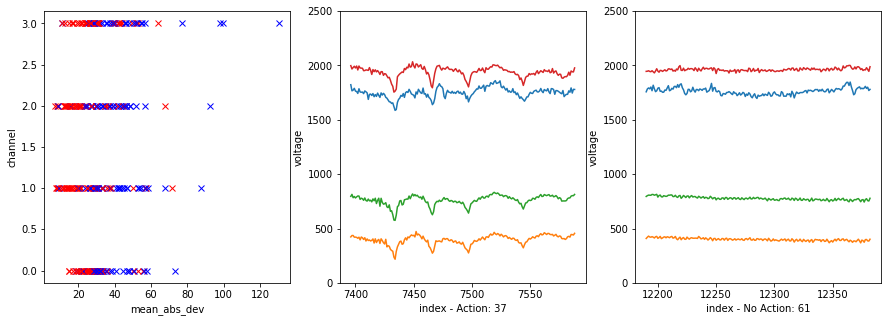

In [34]:
for input in inputsToUse:
    visualize_data(input)

In [35]:
def getMeanAbsDeviation(dchannel):
    return np.transpose(np.mean(np.abs(dchannel - np.mean(dchannel, axis=2, keepdims=True)), axis=2))

def getMean(dchannel):
    return np.transpose(np.mean(dchannel, axis=2))

def getPercentile(dchannel, percent):
    return np.transpose(np.percentile(dchannel, percent, axis=2))

def getSpread(dchannel):
    return np.transpose(np.max(dchannel, axis=2) - np.min(dchannel, axis=2))

def getSpreadPercentile(dchannel, low, high):
    return getPercentile(dchannel, high) - getPercentile(dchannel, low)

In [36]:
# Loads in X and Y
XMean = None
XMeanDev = None
X90 = None
X10 = None
y = None
for i in inputsToUse:
    obs = dc.getObservations(rec_paths[i], label_paths[i], 1000, [0,1,2,3], label_types[i])
    y_channels_groups, ind_groups, t_groups, l_groups = obs
    if XMean is not None:
        XMean = np.concatenate((XMean, getMean(y_channels_groups)))
        XMeanDev = np.concatenate((XMeanDev, getMeanAbsDeviation(y_channels_groups)))
        X90 = np.concatenate((X90, getPercentile(y_channels_groups, 90)))
        X10 = np.concatenate((X10, getPercentile(y_channels_groups, 10)))
        y = np.concatenate((y, l_groups))
    else:
        XMean = getMean(y_channels_groups)
        XMeanDev = getMeanAbsDeviation(y_channels_groups)
        X90 = getPercentile(y_channels_groups, 90)
        X10 = getPercentile(y_channels_groups, 10)
        y = l_groups

X = None
# featureList = [XMean, XMeanDev]
featureList = [XMeanDev, X90]
for feature in featureList:
    if(X is None):
        X = feature
    else:
        X = np.concatenate((X, feature), axis=1)

print(X.shape, y.shape)

(69, 8) (69, 5)


In [37]:
#test-train split
from sklearn.model_selection import train_test_split

X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.33, random_state = 4)

In [38]:
# Create as many classifiers as needed
classifiers = []
for i in range(0, num_enabled):
    classifiers.append(svm.SVC(probability=True))
    classifiers[i].fit(X_res, y_res[:,i])

In [39]:
correct = 0
total = 0

enabledClassifiers = np.arange(0, y.shape[1])[:num_enabled]
RecallRate = np.zeros([num_enabled, 2])
Precision = np.zeros([num_enabled, 2])

# Comment this to test on all data
# X = X_test
# y = y_test

for i in range(X.shape[0]):
    # if you want to make it more or less likely to predict no action change the threshold to a larger/smaller value
    maxVal = 0
    maxInd = 0

    #Enable as many classifiers as you need to
    for c in range(0, len(classifiers)):
        if(classifiers[c].predict_proba(X[i].reshape(1, -1))[0][1]>maxVal):
            maxVal = classifiers[c].predict_proba(X[i].reshape(1, -1))[0][1]
            maxInd = c

#Getting Precision and Recall Data
    if(y[i][maxInd]==1):
        correct+=1
        Precision[maxInd][0]+=1
        RecallRate[maxInd][0]+=1
    for xx in range(num_enabled):
        if(y[i][xx]==1):
            RecallRate[xx][1]+=1
    total+=1
    Precision[maxInd][1]+=1
print(correct/total)
print("Recall")
for row in RecallRate:
    print(row, row[0]/row[1])
print("Precision")
for row in Precision:
    print(row, row[0]/row[1])

0.6811594202898551
Recall
[34. 40.] 0.85
[13. 29.] 0.4482758620689655
Precision
[34. 50.] 0.68
[13. 19.] 0.6842105263157895
